# Unet Testskript
Schneidet das segmentierte Element aus.


In [29]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import json

from unetModules.unet_model import UNet
from unetModules.Utils import Utils
from PIL import Image
from torchmetrics import JaccardIndex
from torchmetrics import Dice

In [30]:
# Data structure for contour polygons
class Polygon:
    points = []
    area = 0
    
    def __init__(self, polygon_points):
        self.points = polygon_points
        
        x_coordinates = [point[0][0] for point in self.points]
        y_coordiantes = [point[0][1] for point in self.points]
              
        # calculation polygon area using shoelace algorithm
        self.area = 0.5 * np.abs(np.dot(x_coordinates,np.roll(y_coordiantes,1))-np.dot(y_coordiantes,np.roll(x_coordinates, 1)))

In [31]:
model_folder_path = "./modelBackups/UnetModel_09_01_2023_Test_100E/"
model_file = "ckpt-unet-100-78.29652310907841.pth"

load_model = model_folder_path + model_file
settings_path = model_folder_path + "logs/settings.json"

#For Schistosoma Mansoni
#input_img_path = "./content/SchistosomaMansoni/testset/2.png"

# For RiverBlindness
input_img_path = "../../content/RiverBlindness/testset/411_HE@6041-1887-6207-2130.jpg"
#input_img_path = "../data/img32.jpg"

display_metrics = False
use_dilation_erosion = True
save_primary_worm = False

# Pixel amount which decieds which polygon to delete in an image
area_treshold = 30000

f = open(settings_path)
settings = json.load(f)
f.close()

color_map = {
    'background'        : [ 0, 0, 0],
    'segmentedObject'    : [ 255, 255, 255]
}

[INFO]CUDA is available!


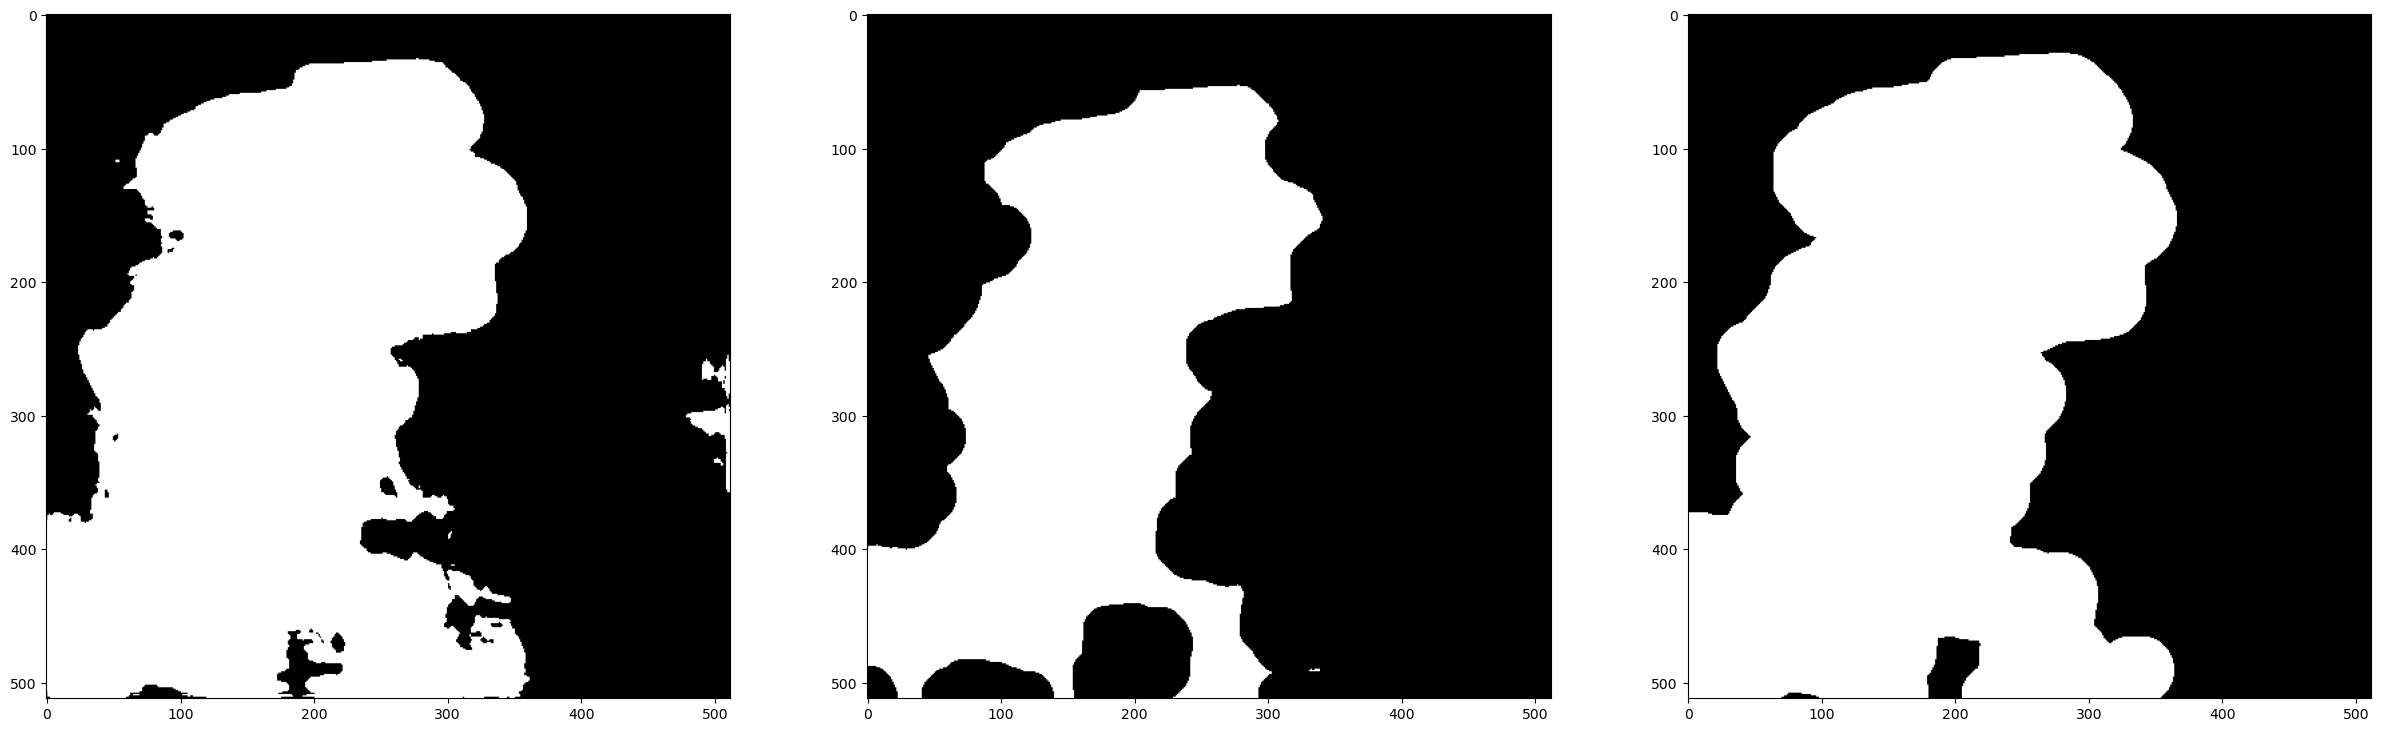

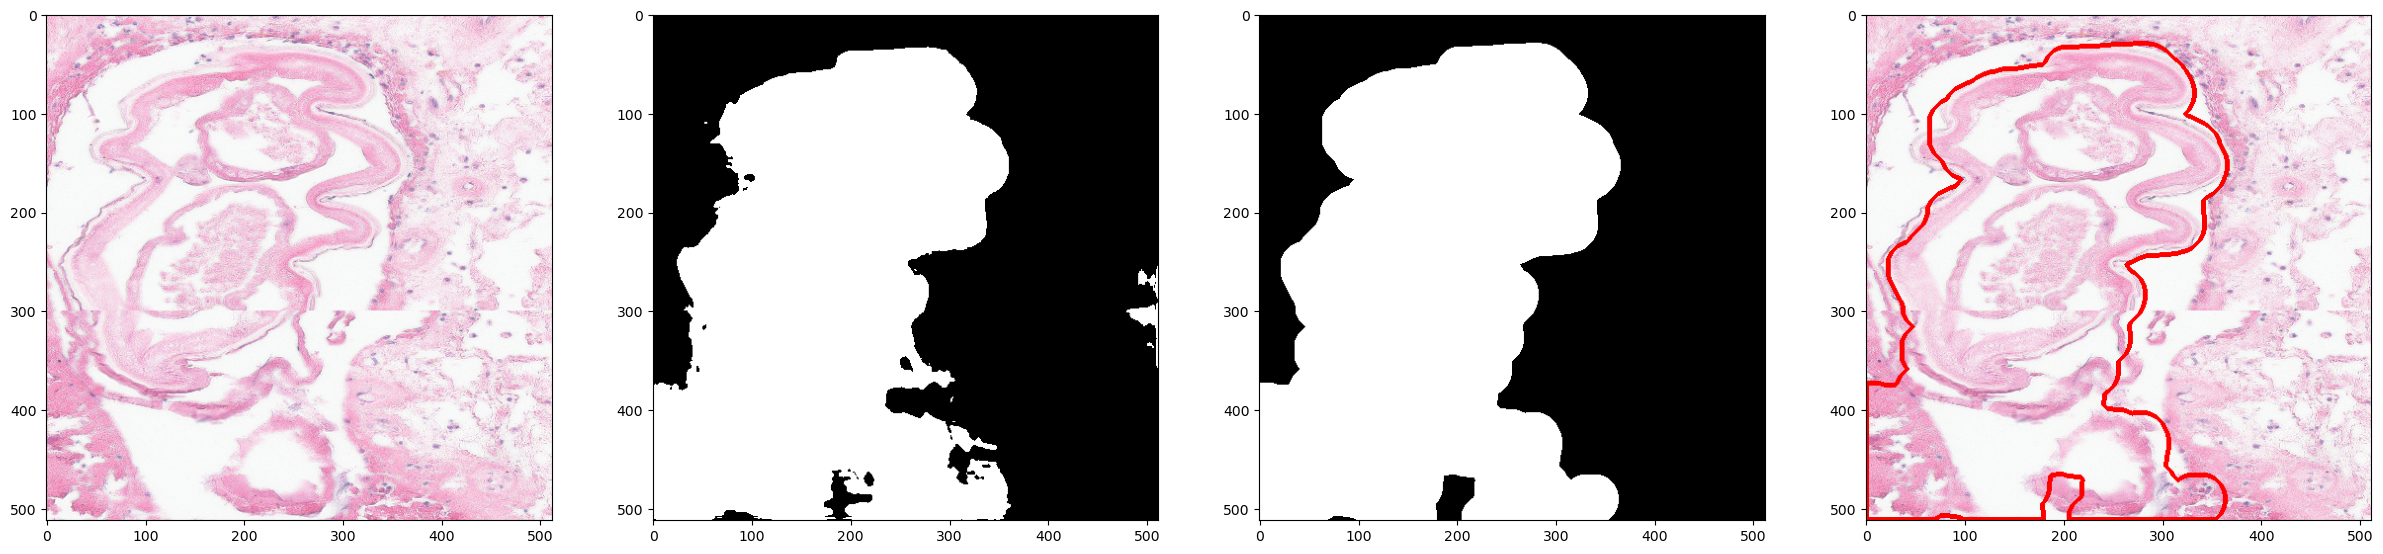

In [32]:
if(settings["cuda"]):
    print("[INFO]CUDA is available!")
    device = "cuda:0"
else:
    print("[INFO] CUDA isn't available!")
    device = "cpu"

trained_model = torch.load(load_model,  map_location=device)

unet = UNet(settings["n_channels"], settings["n_classes"])
unet.load_state_dict(trained_model['state_dict'])
unet = unet.to(device)

input_img_to_predict = Image.open(input_img_path)
input_img_to_predict = cv2.resize(np.array(input_img_to_predict), (512, 512), cv2.INTER_NEAREST)
input_img_tensor = torch.tensor(input_img_to_predict[:,:,0:3]).unsqueeze(0).transpose(2, 3).transpose(1, 2)
input_img_tensor = input_img_tensor.to(device)

with torch.no_grad():   
    out = unet(input_img_tensor.float()).squeeze(0)
    
segmentedImg = out.data.max(0)[1].cpu().numpy()
segmentedImg = segmentedImg.astype('uint8')

if(display_metrics):
    # Load label
    #label = Image.open("../../content/SchistosomaMansoni/testsetLabels/" + os.path.basename(input_img_path))
    label = Image.open("../../content/RiverBlindness/val_labels/" + os.path.basename(input_img_path))
    label = np.array(label)
    label = cv2.resize(label, (512, 512), cv2.INTER_NEAREST)
    label = torch.tensor(label)
    
    jaccard = JaccardIndex(num_classes=settings["n_classes"], average="none")
    dice = Dice(num_classes=settings["n_classes"], average="none")
        
    jaccardIndices = jaccard(torch.tensor(segmentedImg), label).numpy()
    diceScores = dice(torch.tensor(segmentedImg), label).numpy()
    
    print("---------------------------------------------------------------------------------------------------------------------------------------")      
    print(f"Jaccard Index: \t Class[0] = {str(jaccardIndices[0])} \t Class[1] = {str(jaccardIndices[1])} \t mean = {np.mean(jaccardIndices)}")                                  
    print(f"Dice Score: \t Class[0] = {str(diceScores[0])} \t Class[1] = {str(diceScores[1])} \t mean = {np.mean(diceScores)}")
    print("---------------------------------------------------------------------------------------------------------------------------------------")  

# TODO: Vorerst wird eine Bildgröße von 512x512 bearbeitet. Möglichkeit auf Originalgröße anzupassen.
#decoded_segmentedImg = cv2.resize(decoded_segmentedImg, (np.shape(input_img)[1], np.shape(input_img)[0]), cv2.INTER_NEAREST)

if(use_dilation_erosion):   
    erosion_dest = cv2.erode(segmentedImg, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40, 40)))
    dilation_dest = cv2.dilate(erosion_dest, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50, 50)))  

    defig, axs = plt.subplots(1, 3, figsize=(30, 30))
    axs[0].imshow(Utils.decode_segmap(segmentedImg, color_map))
    axs[1].imshow(Utils.decode_segmap(erosion_dest, color_map))
    axs[2].imshow(Utils.decode_segmap(dilation_dest, color_map))
    
    segmentedImg = dilation_dest
    
decoded_segmentedImg = Utils.decode_segmap(segmentedImg, color_map)

cuted_input_image = input_img_to_predict

if(cuted_input_image.shape[2] < 4):
    cuted_input_image = cv2.cvtColor(np.array(cuted_input_image), cv2.COLOR_BGR2BGRA)
     
for iy, ix in np.ndindex(cuted_input_image.shape[:2]):
    if(segmentedImg[iy, ix] == 0):
        cuted_input_image[iy, ix, 3] = 0
        
decoded_segmentedImg_gray = cv2.cvtColor(decoded_segmentedImg, cv2.COLOR_BGR2GRAY)
contours, hierarchy = cv2.findContours(decoded_segmentedImg_gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

input_img_shape = np.shape(input_img_to_predict)

img_width = input_img_shape[1]
img_height = input_img_shape[0]

segmented_polygons = []

for polygon_pionts in contours:
    segmented_polygons.append(Polygon(polygon_pionts))

primary_worm_polygons_contours = []

for polygon in segmented_polygons:
    if(polygon.area > area_treshold):
        primary_worm_polygons_contours.append(polygon.points)
        
input_img_to_save = np.copy(input_img_to_predict)

contour_Img = cv2.drawContours(input_img_to_save, primary_worm_polygons_contours, -1, (255, 0, 0), 3)
         
# fig, axs = plt.subplots(1, 4, figsize=(30, 30))
# axs[0].imshow(input_img_to_predict)
# axs[1].imshow(decoded_segmentedImg)
# axs[2].set_facecolor('xkcd:gray')
# axs[2].imshow(cuted_input_image)
# axs[3].imshow(input_img_to_save)

fig, axs = plt.subplots(1, 4, figsize=(30, 30))
axs[0].imshow(input_img_to_predict)
axs[1].imshow(Utils.decode_segmap(out.data.max(0)[1].cpu().numpy(), color_map))
axs[2].imshow(Utils.decode_segmap(segmentedImg, color_map))
axs[3].imshow(input_img_to_save)

if(save_primary_worm):
    for iy, ix in np.ndindex(input_img_to_save.shape[:2]):
        if(cv2.pointPolygonTest(primary_worm_polygons_contours[0], (ix, iy), False) == -1):
            input_img_to_save[iy, ix, 0] = 0
            input_img_to_save[iy, ix, 1] = 0
            input_img_to_save[iy, ix, 2] = 0
            
    plt.imshow(input_img_to_save)
   
    output_image = Image.fromarray(input_img_to_save)
    output_image.save("./segmentedImages/segImage.png")
        